In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-salary-2.txt")

In [4]:
data.head()

,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


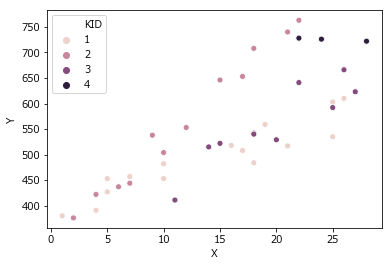

In [6]:
sns.scatterplot(x="X", y="Y", data=data, hue="KID")

In [36]:
X = torch.tensor(data.X).float()
Y = torch.tensor(data.Y).float()
KID = torch.tensor(data.KID).long()

## グループ差を考慮しないモデル式

$Y[n] \sim Normal(a + bX[n], \sigma_Y)$

In [8]:
def model_nogroup(X, Y):
    # 個人的にこれくらいじゃないかという事前情報
    a = pyro.sample("a", dist.Uniform(200, 500))
    b = pyro.sample("b", dist.Uniform(1, 100))
    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 100))
    
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(a + b*X, sigma_y), obs=Y)

In [9]:
nogroup_kernel = NUTS(model_nogroup, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
nogroup_posterior = MCMC(nogroup_kernel, num_chains=4, num_samples=1000, warmup_steps=1000).run(X, Y)

In [10]:
sites = ["a", "b", "sigma_y"]
nogroup_marginal = pd.DataFrame(EmpiricalMarginal(nogroup_posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).numpy(), columns=sites)

In [11]:
nogroup_marginal.quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
a,327.608820,375.168030,423.641028
b,8.329908,11.106856,13.830487
sigma_y,54.885571,67.795273,87.765956


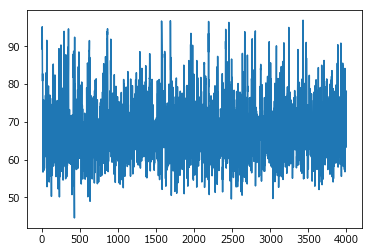

In [14]:
nogroup_marginal.sigma_y.plot()

In [16]:
def pred_model_nogroup(X):
    # 個人的にこれくらいじゃないかという事前情報
    a = pyro.sample("a", dist.Uniform(200, 500))
    b = pyro.sample("b", dist.Uniform(1, 100))
    
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 100))
    
    pyro.sample("y", dist.Normal(a + b*X, sigma_y))
nogroup_predictive = TracePredictive(pred_model_nogroup, nogroup_posterior, num_samples=1000).run(torch.arange(0, 30).float())
nogroup_pred_samples = pd.DataFrame(EmpiricalMarginal(nogroup_predictive, "y")._get_samples_and_weights()[0].numpy())

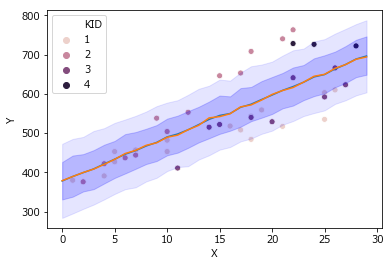

In [19]:
sns.scatterplot(x="X", y="Y", data=data, hue="KID")
plt.plot(np.arange(0, 30), nogroup_pred_samples.mean(0).values)
plt.plot(np.arange(0, 30), nogroup_pred_samples.quantile(0.5).values)
plt.fill_between(np.arange(0, 30), nogroup_pred_samples.quantile(0.1).values, nogroup_pred_samples.quantile(0.9).values, color='blue', alpha=0.1)
plt.fill_between(np.arange(0, 30), nogroup_pred_samples.quantile(0.25).values, nogroup_pred_samples.quantile(0.75).values, color='blue', alpha=0.2)

## グループ差を考慮したモデル式

$Y[n] \sim Normal(a[KID[n]] + b[KID[n]]X[n], \sigma_Y)$

In [157]:
def model_group(X, KID, Y):
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 100))
    # 個人的にこれくらいじゃないかという事前情報
    a = pyro.sample("a", dist.Normal(200, 1000).expand([4]))
    b = pyro.sample("b", dist.Normal(0,100).expand([4]))
    
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(a[KID-1] + b[KID-1]*X, sigma_y), obs=Y)

In [158]:
group_kernel = NUTS(model_group, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
group_posterior = MCMC(group_kernel, num_chains=4, num_samples=1000, warmup_steps=1000).run(X, KID, Y)

In [159]:
marginal = group_posterior.marginal(["a", "b", "sigma_y"]).support(flatten=True)

In [160]:
pd.DataFrame(marginal["a"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,359.101811,386.498962,414.766610
1,294.773468,328.644531,361.446307
2,244.031510,313.497131,383.463889
3,430.530319,730.139893,1055.372809


In [161]:
pd.DataFrame(marginal["b"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,5.824417,7.535970,9.221857
1,17.384707,19.851243,22.362975
2,9.081367,12.481362,15.881652
3,-13.314668,-0.163341,11.955927


In [162]:
pd.DataFrame(marginal["sigma_y"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,21.300971,26.915577,35.437887


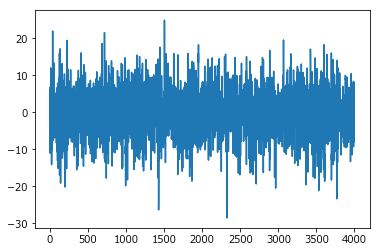

In [163]:
pd.DataFrame(marginal["b"].numpy())[3].plot()

## 階層モデル

$Y[n] \sim Normal(a[KID[]n]] + b[KID[n]]X[n], \sigma_Y)$

$a[k] = a_{global_average} + a_{difference}[k]$

$a_{difference}[k] \sim Normal(0, \sigma_a)$

$b[k] = b_{global_average} + b_{difference}[k]$

$b_{difference}[k] \sim Normal(0, \sigma_b)$

In [222]:
def hierarchical_model(X, KID, Y):
    a_global = pyro.sample("a_global", dist.Normal(200, 1000))
    b_global = pyro.sample("b_global", dist.Normal(0, 1000))
    sigma_a = pyro.sample("sigma_a", dist.Uniform(0, 1000))
    sigma_b = pyro.sample("sigma_b", dist.Uniform(0, 1000))
    sigma_y = pyro.sample("sigma_y", dist.Uniform(0, 1000))
    
    a_diff = pyro.sample("a_diff", dist.Normal(0, sigma_a).expand([4]))
    b_diff = pyro.sample("b_diff", dist.Normal(0, sigma_b).expand([4]))
    a = a_global + a_diff
    b = b_global + b_diff
    
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(a[KID-1]+b[KID-1]*X, sigma_y), obs=Y)
    

In [223]:
hierarchical_model(X, KID, Y)

In [224]:
hierarchical_kernel = NUTS(hierarchical_model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
hierarchical_posterior = MCMC(hierarchical_kernel, num_chains=2, num_samples=1000, warmup_steps=500).run(X, KID, Y)

In [225]:
marginal = hierarchical_posterior.marginal(["a_global", "b_global", "sigma_a", "sigma_b", "sigma_y"]).support(flatten=True)

In [226]:
pd.DataFrame(marginal["a_global"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,207.032233,366.574295,675.486505


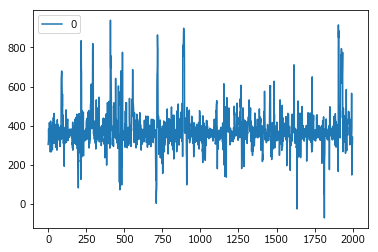

In [227]:
pd.DataFrame(marginal["a_global"].numpy()).plot()

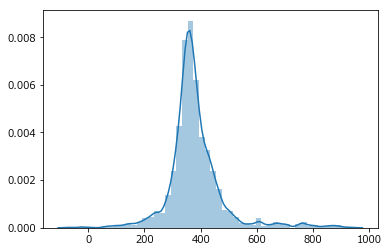

In [228]:
sns.distplot(marginal["a_global"].numpy())

In [229]:
pd.DataFrame(marginal["b_global"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,0.81152,12.49659,33.259377


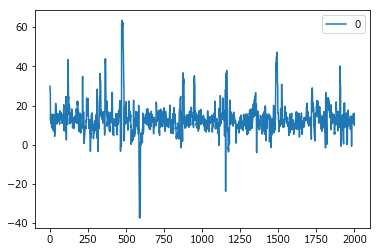

In [230]:
pd.DataFrame(marginal["b_global"].numpy()).plot()

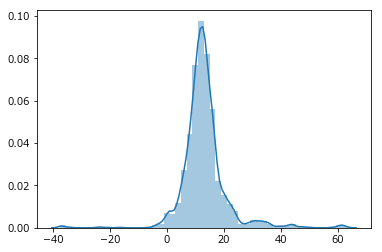

In [231]:
sns.distplot(marginal["b_global"].numpy())

In [232]:
pd.DataFrame(marginal["sigma_a"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,13.623278,94.202747,545.008496


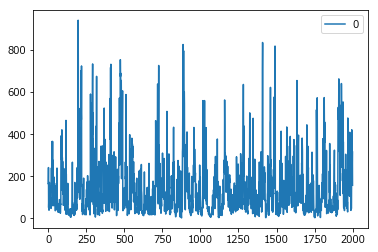

In [233]:
pd.DataFrame(marginal["sigma_a"].numpy()).plot()

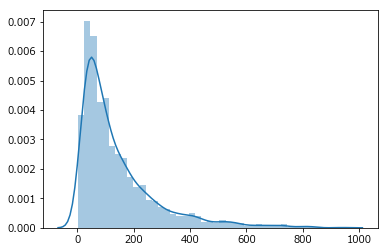

In [234]:
sns.distplot(marginal["sigma_a"])

In [235]:
pd.DataFrame(marginal["sigma_b"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,3.129411,8.417203,55.358565


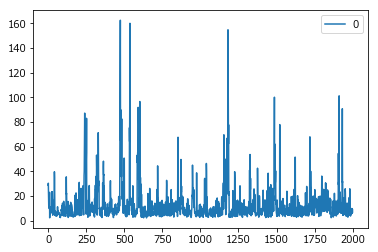

In [237]:
pd.DataFrame(marginal["sigma_b"].numpy()).plot()

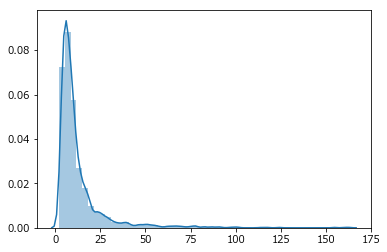

In [238]:
sns.distplot(marginal["sigma_b"])

In [236]:
pd.DataFrame(marginal["sigma_y"].numpy()).quantile([0.025, 0.5, 0.975]).T

,0.025,0.5,0.975
0,22.513909,28.446425,37.25419


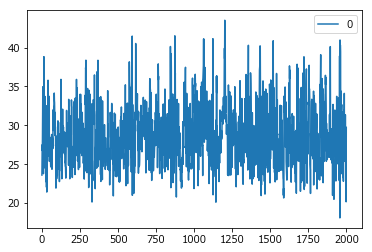

In [240]:
pd.DataFrame(marginal["sigma_y"].numpy()).plot()

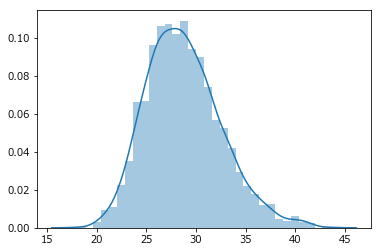

In [239]:
sns.distplot(marginal["sigma_y"])